# Group 17 社媒期末專案

**組員:** <br>
M134020004 郭佳沄 <br>
M134020017 李恩榮 <br>
M134020027 陳昱璋 (組長) <br>
M134020037 陳宥齊 <br>

**報告連結:** <br>
https://youtu.be/QBf6OGumbNE

**主題:** <br>
從 PTT 八卦版、電影版抓取「黃牛」相關文章進行情緒分析及文件分類 <br>

**動機和分析目的:** <br>
疫情解封後，演唱會、電影首映等熱門活動日益增多，但只要遇到搶票話題，「黃牛」幾乎都會被點名討論，大家常常會抱怨票很難搶、價格被炒高，也有人分享自己轉賣的經驗。所以我們想透過這個現象做分析，抓取 PTT 上關於「黃牛」的討論文章，看看網友到底是在討論什麼？情緒是偏向負面，還是其實有人是支持或理解黃牛行為，除了情緒之外，我們也想了解這些文章可以分成哪些類型，比如是在講購票經驗、抱怨制度，還是提出對策？也希望可以針對不同方面的黃牛，例如:演唱會、電影、蛋黃酥等，分類不同層面的黃牛現象。 <br>

**資料集:** <br>
資料來源：PTT <br>
版別：八卦、電影 <br>
時間範圍：2024/01/01 ~ 2025/06/11 <br>
工作流程平台搜尋關鍵字：黃牛 <br>

### 情緒分析

##### 前置處理

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud
import jieba
%matplotlib inline

In [ ]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./dict/SourceHanSansTW-Regular.otf")

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

In [ ]:
df = pd.read_csv("./raw_data/SMA_FinalData.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,Ralfchen0429,Gossiping,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""VVizZ"", ""cmt...",111.81.89.31,2024-01-17 01:43:28,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17,chun0303,Gossiping,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kent00216"", ...",111.71.66.147,2024-01-17 01:50:45,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20,P00832129,Gossiping,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""dharma123"", ...",61.64.27.184,2024-01-21 01:27:40,ptt
3,4,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,[新聞]YOASOBI新莊秀台語「打給厚」！飆唱5億,2024-01-21,cl3bp6,Gossiping,YOASOBI新莊秀台語「打給厚」！飆唱5億神曲《Idol》2000粉瘋狂\nhttps:/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""OPPAISuki"", ...",49.216.160.209,2024-01-22 01:30:39,ptt
4,5,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,[新聞]YOASOBI新莊門票買不到！爆出11人花38萬,2024-01-22,icedog122,Gossiping,1.媒體來源: 今日新聞\n2.記者署名: 陳雅蘭\n3.完整新聞標題:\n4.完整新聞內文...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Qinsect"", ""c...",220.137.236.231,2024-01-23 01:30:29,ptt


In [ ]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,。他們家東西基本上吃過一次就好。怎說？食材擺出來就那樣。以前沒在綁帳號的時候訂位滿方便的。後...
1,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,1.媒體來源:。民視新聞。2.記者署名:。陳姵妡、陳家祥。3.完整新聞標題:。「大港開唱」開...
2,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,各位阿肥好。本肥百思不解。演唱會票黃牛被人撻伐。原因是大量佔為己有。那房市也是有一些人佔為己...
3,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,[新聞]YOASOBI新莊秀台語「打給厚」！飆唱5億,2024-01-21,YOASOBI新莊秀台語「打給厚」！飆唱5億神曲《Idol》2000粉瘋狂\nhttps:/...,YOASOBI新莊秀台語「打給厚」！飆唱5億神曲《Idol》2000粉瘋狂 New Taip...
4,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,[新聞]YOASOBI新莊門票買不到！爆出11人花38萬,2024-01-22,1.媒體來源: 今日新聞\n2.記者署名: 陳雅蘭\n3.完整新聞標題:\n4.完整新聞內文...,1.媒體來源: 今日新聞2.記者署名: 陳雅蘭3.完整新聞標題:4.完整新聞內文:。日本人氣...


In [ ]:
#斷句
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好
2,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,怎說
3,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,食材擺出來就那樣
4,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,以前沒在綁帳號的時候訂位滿方便的


In [ ]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
#有要加再說 jieba.add_word('自助餐')

In [ ]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好
2,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,怎說
3,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,食材擺出來就那樣
4,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,以前沒在綁帳號的時候訂位滿方便的
5,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,後來一堆黃牛亂搞後就綁定帳號


In [ ]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head()

Building prefix dict from c:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\final_project\dict\dict.txt ...
Dumping model to file cache C:\Users\acer\AppData\Local\Temp\jieba.u61f86b4bc6166451125cb5ade49aaaa6.cache
Loading model cost 2.122 seconds.
Prefix dict has been built successfully.


,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,東西
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,基本
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,上吃過
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,一次


In [ ]:
# 停用字這裡之後再看看要加什麼,先用原本的檔案

stopwords = [line.strip() for line in open('dict/stopwords_w6.txt', 'r', encoding='utf-8').readlines()]
# stopwords_manual = ["吃到飽", "餐廳", "名稱", "消費", "時間", "地址", "營業", "吃起來", "一點", "電話", "每人", "平均", "價位", "吃到", "看到"]
# stopwords.extend(stopwords_manual)

In [ ]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head()

,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,東西
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,上吃過
2,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,怎說
3,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,食材
3,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,擺出來


In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [ ]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2024-01-16,Re:[問卦]想抵制饗賓集團的+1好嗎,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,東西,NaN
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2024-01-16,Re:[問卦]想抵制饗賓集團的+1好嗎,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,上吃過,NaN
2,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2024-01-16,Re:[問卦]想抵制饗賓集團的+1好嗎,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,怎說,NaN
3,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2024-01-16,Re:[問卦]想抵制饗賓集團的+1好嗎,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,食材,NaN
4,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2024-01-16,Re:[問卦]想抵制饗賓集團的+1好嗎,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,擺出來,NaN


##### 正負向情緒詞彙頻率折線圖

In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count.head(10)

,artDate,sentiments,size
1,2024-01-16,negative,2
3,2024-01-17,negative,2
4,2024-01-17,positive,8
6,2024-01-21,negative,10
7,2024-01-21,positive,12
10,2024-01-22,negative,2
11,2024-01-22,positive,4
15,2024-01-25,positive,4
14,2024-01-25,negative,2
19,2024-01-26,negative,7


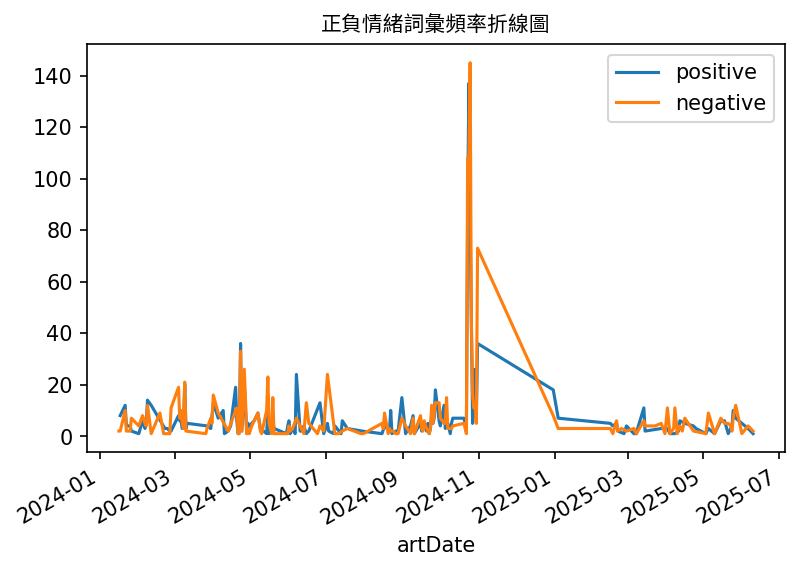

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

可以看到在2024/10到2024/11突然討論度急劇上升，查看原始資料可以發現，10月到11月是周杰倫演唱會的購票時間，所以這段時間有許多人在討論有關黃牛的問題

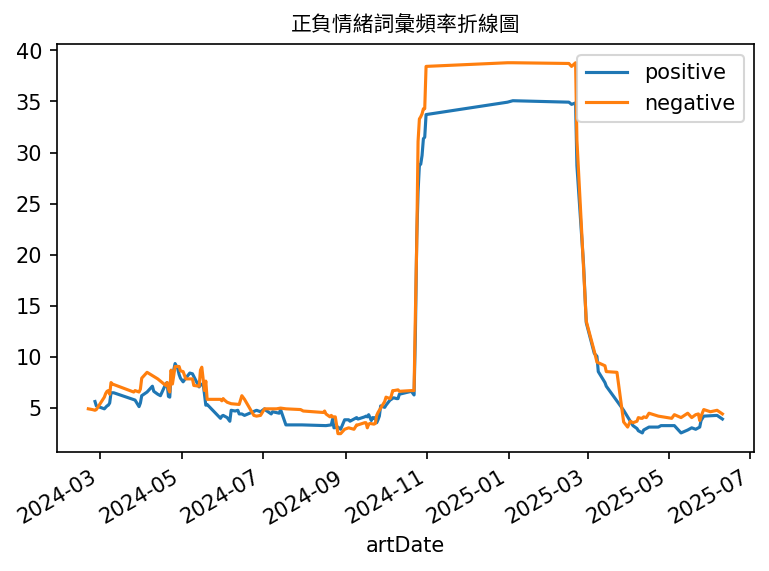

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

由此看來，有關於黃牛的問題，大眾還是抱持較負面的態度，而正向的文章大多在說明不要去買黃牛票之類的內容

##### 負向情緒詞彙比例折線圖

In [ ]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

,artDate,sentiments,size,ratio
1,2024-01-16,negative,2,1.000000
3,2024-01-17,negative,2,0.200000
4,2024-01-17,positive,8,0.800000
6,2024-01-21,negative,10,0.454545
7,2024-01-21,positive,12,0.545455
10,2024-01-22,negative,2,0.333333
11,2024-01-22,positive,4,0.666667
15,2024-01-25,positive,4,0.666667
14,2024-01-25,negative,2,0.333333
19,2024-01-26,negative,7,0.777778


In [ ]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '負向情緒比例折線圖')

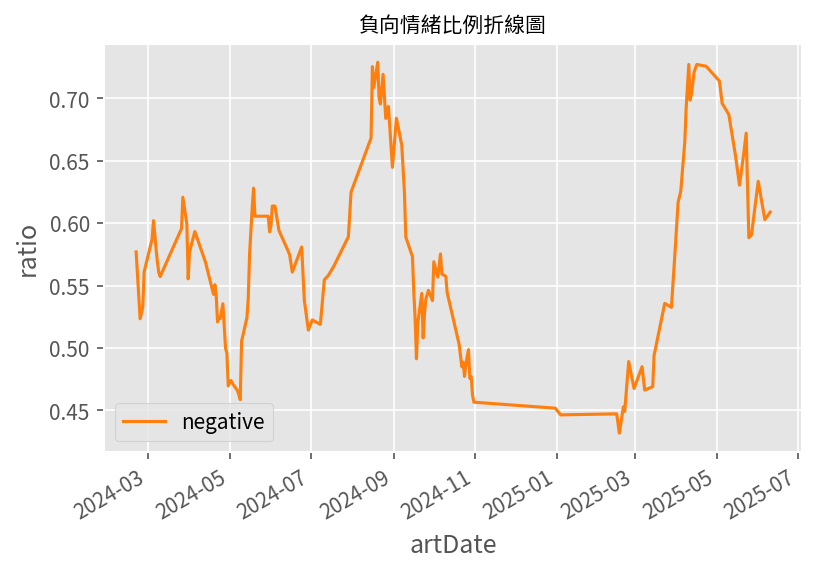

In [ ]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("負向情緒比例折線圖", fontproperties=fprop)

8月底是台灣F1賽車展門票開賣，4月底是五月天演唱會門票開賣，所以這兩個時間點的對於黃牛的負向情緒會較多

##### 正負向情緒分數折線圖

In [ ]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2024-01-16,2.0,0.0
1,2024-01-17,2.0,8.0
2,2024-01-21,10.0,12.0
3,2024-01-22,2.0,4.0
4,2024-01-25,2.0,4.0


In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2024-01-16,2.0,0.0,-2.0
1,2024-01-17,2.0,8.0,6.0
2,2024-01-21,10.0,12.0,2.0
3,2024-01-22,2.0,4.0,2.0
4,2024-01-25,2.0,4.0,2.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

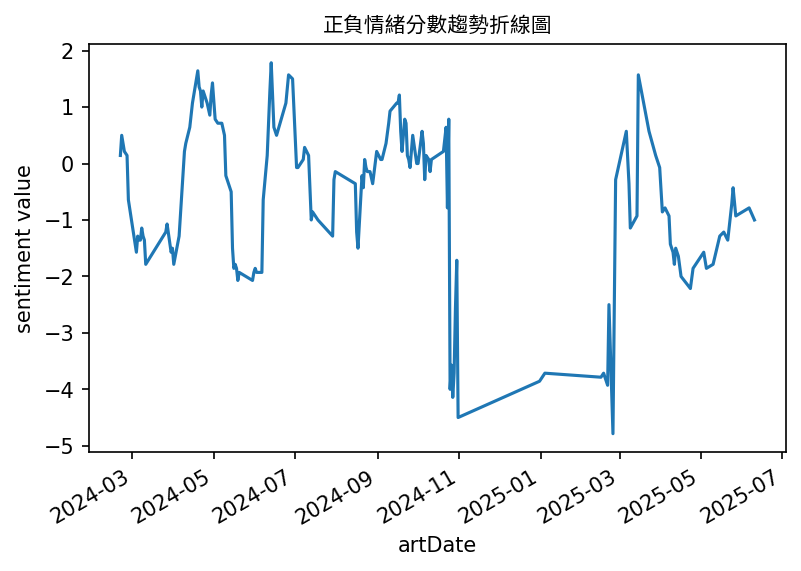

In [ ]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

這樣看下來好像在2024/10月底前的情緒比較偏向正面，但2024/11到2025/3卻突然下降並維持了一段時間，可能跟周杰倫演唱會搶票有關

##### 以文章為單位做情緒分析

In [ ]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,affect,2
1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,negative,2
2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,affect,10
3,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,negative,2
4,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,positive,8
5,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,affect,20
6,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,negative,10
7,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,positive,12
8,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,affect,6
9,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,anger,2


In [ ]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2.0,0.0,0.0,2.0,0.0,0.0
1,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,10.0,0.0,0.0,2.0,8.0,0.0
2,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,20.0,0.0,0.0,10.0,12.0,0.0
3,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,6.0,2.0,0.0,2.0,4.0,0.0
4,https://www.ptt.cc/bbs/Gossiping/M.1706180509....,6.0,1.0,0.0,2.0,4.0,0.0


In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2.0,0.0,0.0,2.0,0.0,0.0,-2.0
1,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,10.0,0.0,0.0,2.0,8.0,0.0,6.0
2,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,20.0,0.0,0.0,10.0,12.0,0.0,2.0
3,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,6.0,2.0,0.0,2.0,4.0,0.0,2.0
4,https://www.ptt.cc/bbs/Gossiping/M.1706180509....,6.0,1.0,0.0,2.0,4.0,0.0,2.0


In [ ]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,2.0,0.0,0.0,2.0,0.0,0.0,-2.0,負向
1,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,10.0,0.0,0.0,2.0,8.0,0.0,6.0,正向
2,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,20.0,0.0,0.0,10.0,12.0,0.0,2.0,正向
3,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,6.0,2.0,0.0,2.0,4.0,0.0,2.0,正向
4,https://www.ptt.cc/bbs/Gossiping/M.1706180509....,6.0,1.0,0.0,2.0,4.0,0.0,2.0,正向
5,https://www.ptt.cc/bbs/Gossiping/M.1706283044....,5.0,3.0,0.0,3.0,2.0,0.0,-1.0,負向
6,https://www.ptt.cc/bbs/Gossiping/M.1706284774....,4.0,1.0,3.0,4.0,0.0,0.0,-4.0,負向
7,https://www.ptt.cc/bbs/Gossiping/M.1706753312....,6.0,1.0,0.0,4.0,1.0,0.0,-3.0,負向
8,https://www.ptt.cc/bbs/Gossiping/M.1707052435....,14.0,6.0,0.0,8.0,6.0,1.0,-2.0,負向
9,https://www.ptt.cc/bbs/Gossiping/M.1707209352....,8.0,1.0,0.0,5.0,3.0,0.0,-2.0,負向


In [ ]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

clear_df_sentiment.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16,Ralfchen0429,Gossiping,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""VVizZ"", ""cmt...",111.81.89.31,2024-01-17 01:43:28,ptt,負向
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17,chun0303,Gossiping,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kent00216"", ...",111.71.66.147,2024-01-17 01:50:45,ptt,正向
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20,P00832129,Gossiping,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""dharma123"", ...",61.64.27.184,2024-01-21 01:27:40,ptt,NaN
3,4,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,[新聞]YOASOBI新莊秀台語「打給厚」！飆唱5億,2024-01-21,cl3bp6,Gossiping,YOASOBI新莊秀台語「打給厚」！飆唱5億神曲《Idol》2000粉瘋狂\nhttps:/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""OPPAISuki"", ...",49.216.160.209,2024-01-22 01:30:39,ptt,正向
4,5,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,[新聞]YOASOBI新莊門票買不到！爆出11人花38萬,2024-01-22,icedog122,Gossiping,1.媒體來源: 今日新聞\n2.記者署名: 陳雅蘭\n3.完整新聞標題:\n4.完整新聞內文...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Qinsect"", ""c...",220.137.236.231,2024-01-23 01:30:29,ptt,正向


In [ ]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2024-01-16,負向,1
1,2024-01-17,正向,1
2,2024-01-21,正向,1
3,2024-01-22,正向,1
4,2024-01-25,正向,1
...,...,...,...
216,2025-05-25,正向,2
217,2025-05-27,負向,3
218,2025-06-01,負向,1
219,2025-06-06,負向,1


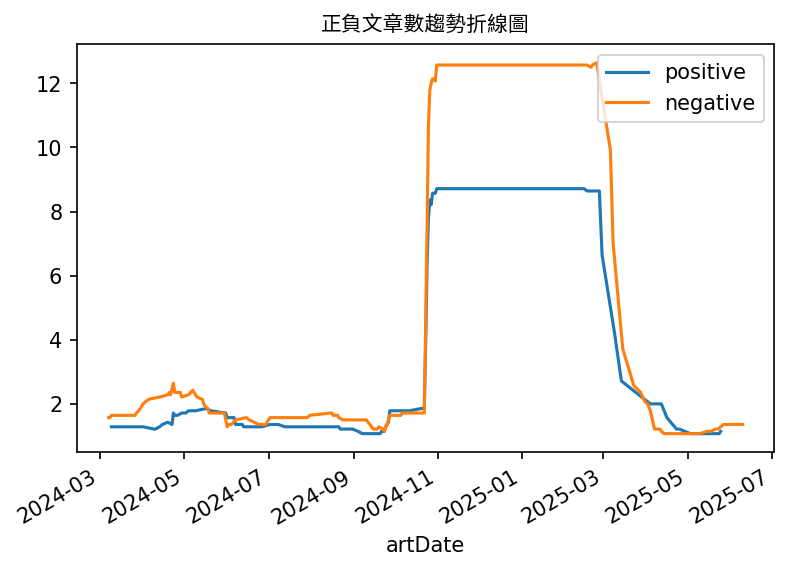

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

這裡就看到周杰倫演唱會搶票那一段時間的討論度都提高不少，且負面的文章數又超越正面的文章數

##### 找情緒代表字

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

,word,sentiments,size
1065,詐騙,negative,73
1064,詐騙,anger,73
1063,詐騙,affect,73
145,八卦,affect,73
146,八卦,negative,73
1135,違法,negative,46
1134,違法,affect,46
406,希望,affect,45
407,希望,positive,45
685,朋友,affect,44


In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
407,希望,positive,45
686,朋友,positive,44
282,喜歡,positive,37
148,公平,positive,33
1054,解決,positive,32
541,成功,positive,32
849,獎金,positive,32
141,免費,positive,30
954,簡單,positive,29
263,吸引,positive,26


In [ ]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
1065,詐騙,negative,73
146,八卦,negative,73
1135,違法,negative,46
1062,詐欺,negative,37
1045,處罰,negative,35
930,禁止,negative,28
838,犯罪,negative,28
1139,違規,negative,26
1058,討厭,negative,21
580,抱怨,negative,19


C:\Users\acer\AppData\Local\Temp\ipykernel_3692\391454114.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\acer\AppData\Local\Temp\ipykernel_3692\391454114.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

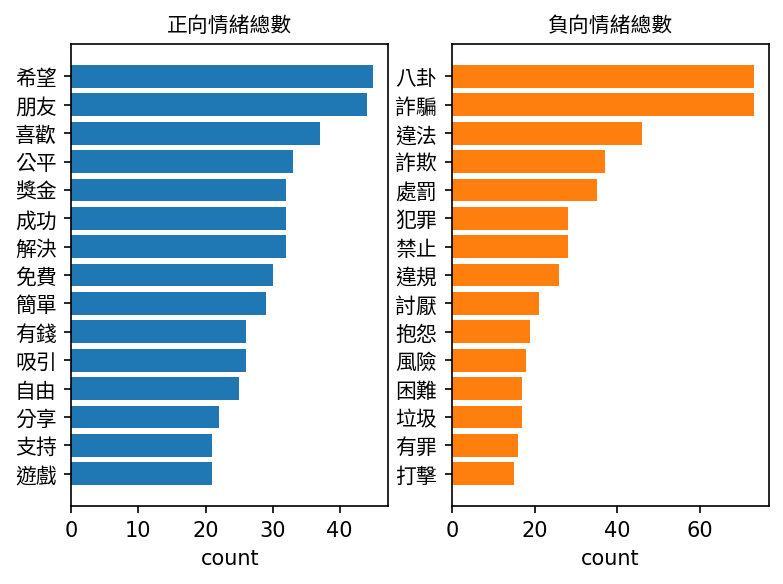

In [ ]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

- 正向裡有“解決”、“自由”等辭彙，在原資料集中的意思應該是：要怎麼解決黃牛問題、要買黃牛票是他的自由、自由的市場等等，應該屬於中性或是不正向的意思
- 在負向的部分出現許多“詐騙”、”詐欺“、”禁止“、”違法“、”處罰“等字眼，顯示出大眾對於黃牛處置方式的想法

##### 詞彙關係分析
可以直接看最後一cell，看前十大TF-IDF的

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [ ]:
import matplotlib

# 新增字體
matplotlib.font_manager.fontManager.addfont('./dict/taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

In [ ]:
#匯入資料
df = pd.read_csv('./raw_data/SMA_FinalData.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,Ralfchen0429,Gossiping,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""VVizZ"", ""cmt...",111.81.89.31,2024-01-17 01:43:28,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17 00:00:39,chun0303,Gossiping,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kent00216"", ...",111.71.66.147,2024-01-17 01:50:45,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20 17:12:37,P00832129,Gossiping,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""dharma123"", ...",61.64.27.184,2024-01-21 01:27:40,ptt


In [ ]:
MetaData = df.copy()

# 移除不需要的欄位
drop_cols = ['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
MetaData.drop(drop_cols, axis=1, inplace=True)

# 去除 artContent 為空的列
MetaData.dropna(subset=['artContent'], axis=0, how='any', inplace=True)

# 只保留中文字，並存入 sentence 欄位
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17 00:00:39,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20 17:12:37,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords_w6.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from c:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\final_project\dict\dict.txt.big ...
Dumping model to file cache C:\Users\acer\AppData\Local\Temp\jieba.u2de33604d95b59305b463510026466bd.cache
Loading model cost 2.928 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,東西
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17 00:00:39,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...,吃過
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20 17:12:37,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...,怎說


In [ ]:
food_df = MetaData.copy()
food_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17 00:00:39,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20 17:12:37,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...


In [ ]:
# 保留需要的欄位
food_df = food_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
food_df['word'] = food_df.sentence.apply(getToken).map(' '.join)

food_df.head()

,system_id,sentence,word
0,1,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,東西 吃過 怎說 食材 擺出來 帳號 訂位 一堆 黃牛 亂搞 綁定 帳號 機車 先付 訂金 ...
1,2,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...,民視 新聞記者 署名 陳家 大港 開唱 開賣 秒殺 實名制 杜絕 黃牛 國內外 天團 夢幻 ...
2,3,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...,阿肥 本肥 百思不解 演唱會 黃牛 撻伐 原因 為己 房市 為己 導致 價格 越來越 買房 ...
3,4,新莊秀台語打給厚飆唱億神曲粉瘋狂記者陳薇安新北報導日本天團為動畫我推的孩子創作演唱創下串流音...,新莊 秀台語 打給 神曲 瘋狂 安新北 日本 天團 動畫 孩子 創作 演唱 創下 串流 音樂...
4,5,媒體來源今日新聞記者署名陳雅蘭完整新聞標題完整新聞內文日本人氣雙人組合今日晚間點將在新莊開唱...,今日 新聞記者 署名 雅蘭 日本 人氣 雙人 組合 今日 晚間 點將 新莊 開唱 門票 開賣...


In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(food_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一下子,一不小心,一个,一中,一事,一二千,一二年,一二百萬,一人,一人組,...,鼓掌,鼻子,鼻孔,鼻涕,齊備,龍家,龍族,龍湧現,龍潭,龐大
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
778,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一下子,一不小心,一个,一中,一事,一二千,一二年,一二百萬,一人,一人組,...,鼓掌,鼻子,鼻孔,鼻涕,齊備,龍家,龍族,龍湧現,龍潭,龐大
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一下子,一不小心,一个,一中,一事,一二千,一二年,一二百萬,一人,...,鼓掌,鼻子,鼻孔,鼻涕,齊備,龍家,龍族,龍湧現,龍潭,龐大
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一下子,0.0
1,2,一下子,0.0
2,3,一下子,0.0
3,4,一下子,0.0
4,5,一下子,0.0
...,...,...,...
11475228,777,龐大,0.0
11475229,778,龐大,0.0
11475230,779,龐大,0.0
11475231,780,龐大,0.0


In [ ]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)

    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

C:\Users\acer\AppData\Local\Temp\ipykernel_3692\3561604680.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
5008,黃牛,73
0,一下子,49
3197,演唱會,40
1273,周杰倫,37
4731,門票,34
1824,實名制,32
1,一不小心,31
5009,黃牛票,25
1940,巨蛋,23
1189,台灣,22


##### Bigram

In [ ]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [ ]:
food_bigram = MetaData.copy()

food_bigram["word"] = food_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
food_bigram = food_bigram.explode('word')

food_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,東西 吃過
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,吃過 怎說
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,怎說 食材


In [ ]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram['word'].value_counts().reset_index()

food_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,演唱會 門票,161
1,台北 巨蛋,83
2,周杰倫 演唱會,79
3,產業 發展,45
4,文化 創意,43
5,黃牛 黃牛,43
6,寶可夢 中心,41
7,創意 產業,40
8,售票 系統,36
9,地方 政府,32


In [ ]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,東西 吃過
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,吃過 怎說
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,怎說 食材


In [ ]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('演唱會', '門票'), 161),
 (('台北', '巨蛋'), 83),
 (('周杰倫', '演唱會'), 79),
 (('產業', '發展'), 45),
 (('黃牛', '黃牛'), 43)]

In [ ]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [ ]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

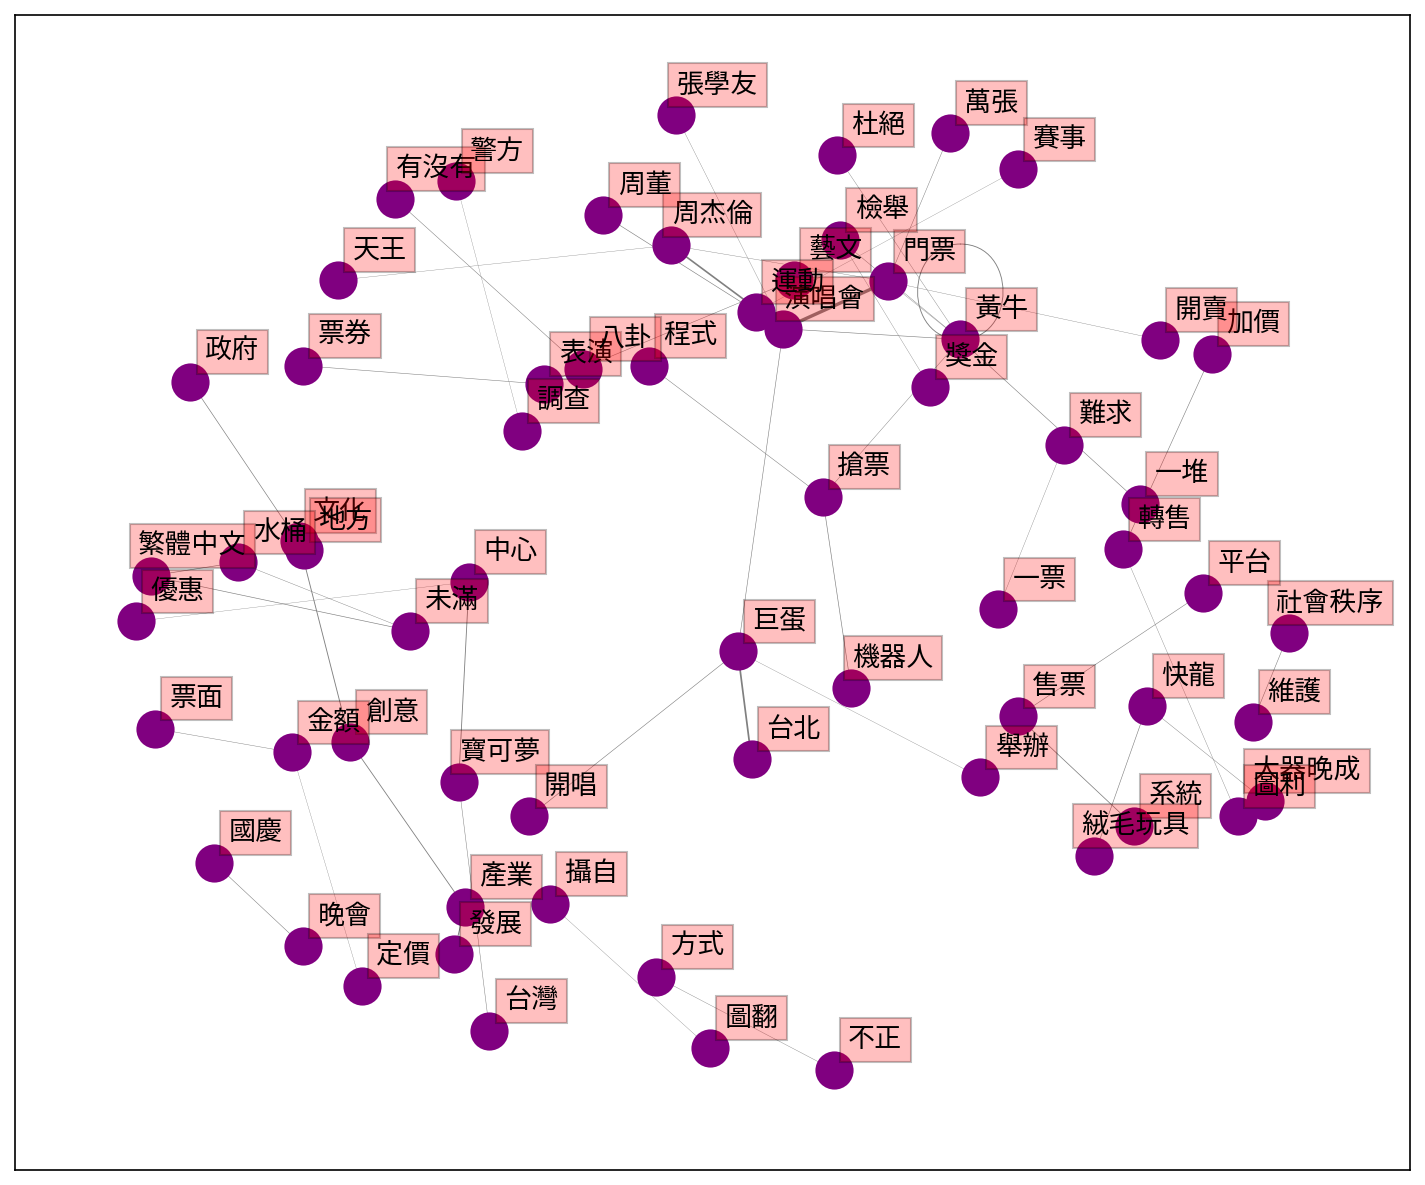

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

從這張圖可以看到一些有關黃牛的議題，像是搶票機器人、轉售圖利以及黃牛違反文化創意產業發展法遭到起訴等，大眾也希望能夠杜絕黃牛問題。
再來周杰倫演唱會門票以及台北巨蛋的edge特別高，也顯示出在之前觀察到的2024/10至2025/3黃牛的討論度上升也是因為周董開了演唱會。

##### 計算 Pairwise correlation，找特定字詞最高相關的詞

In [ ]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,東西 吃過 怎說 食材 擺出來 帳號 訂位 一堆 黃牛 亂搞 綁定 帳號 機車 先付 訂金 ...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17 00:00:39,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...,民視 新聞記者 署名 陳家 大港 開唱 開賣 秒殺 實名制 杜絕 黃牛 國內外 天團 夢幻 ...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20 17:12:37,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...,阿肥 本肥 百思不解 演唱會 黃牛 撻伐 原因 為己 房市 為己 導致 價格 越來越 買房 ...


In [ ]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

In [ ]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

In [ ]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
26708,中心,寶可夢,0.986990
2489,寶可夢,中心,0.986990
5978,銀行,仲介,0.972595
83419,仲介,銀行,0.972595
46665,比賽,梅西,0.937177
49655,梅西,比賽,0.937177
45167,水桶,未滿,0.929058
50250,未滿,水桶,0.929058
55355,梅西,球迷,0.926240
46684,球迷,梅西,0.926240


In [ ]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "周董")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "巨蛋")].sort_values(by = ['cor'], ascending = False).head(10)

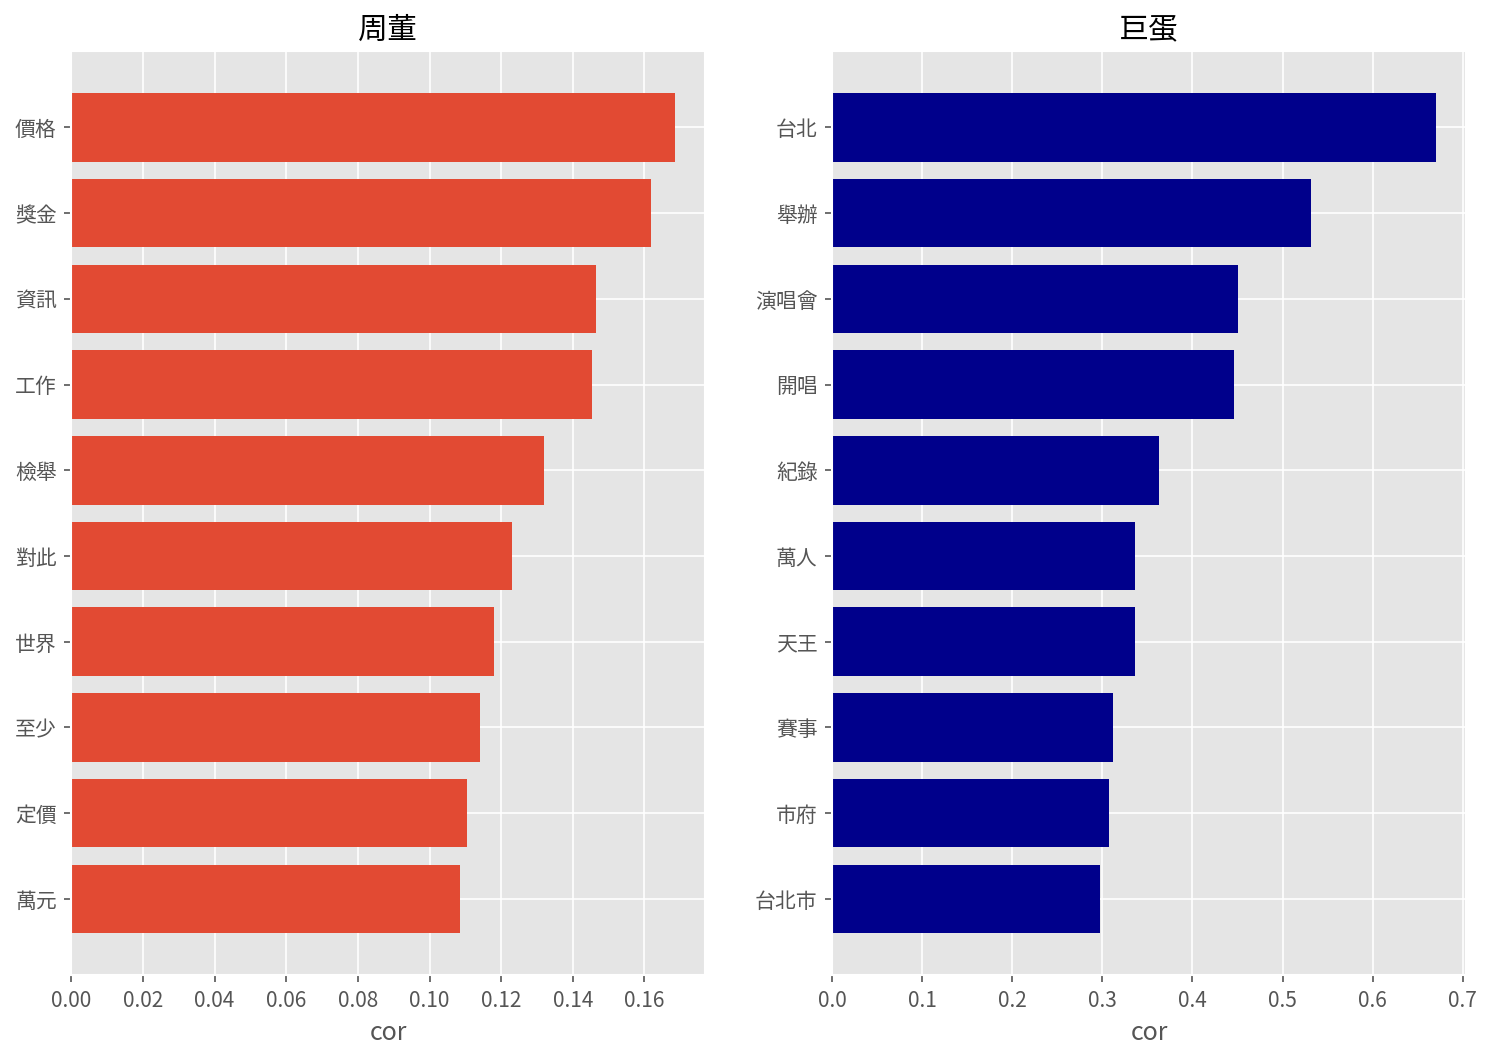

In [ ]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('周董')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('巨蛋')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

從周董的相關詞比較沒有發現什麼，而巨蛋的相關詞大部分都是跟演唱會相關的

##### 用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.4的組合

In [ ]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [ ]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.4]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,巨蛋,台北,0.670571
1,演唱會,台北,0.463103
2,開唱,台北,0.451878
3,提供,台灣,0.409176
4,演唱會,周杰倫,0.510757
...,...,...,...
61,轉售,門票,0.423055
62,台北,開唱,0.451878
63,巨蛋,開唱,0.446482
64,演唱會,開唱,0.466531


In [ ]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

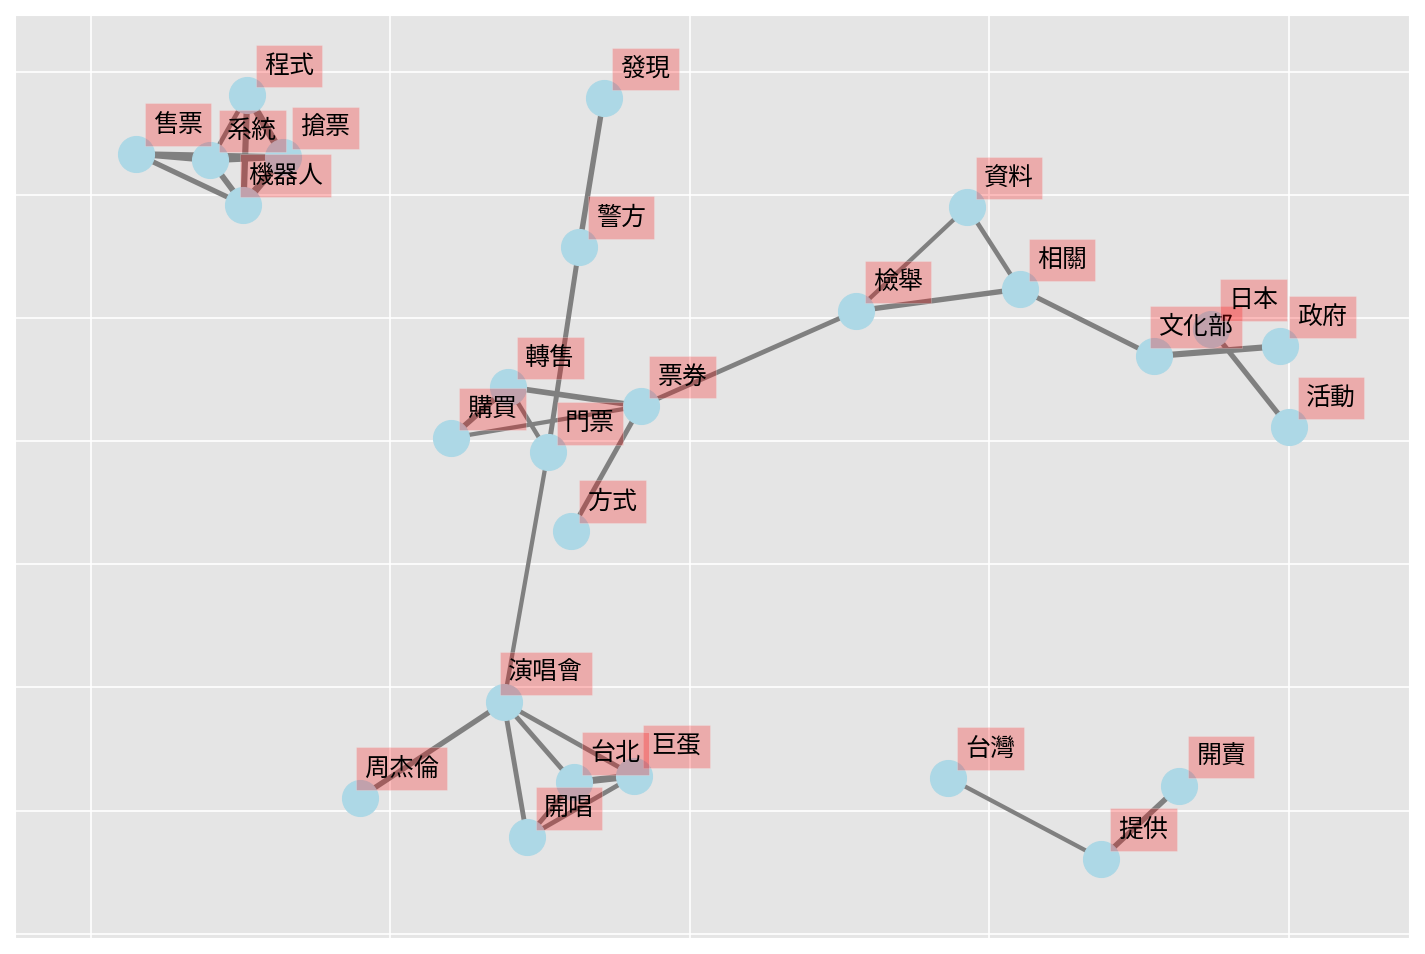

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

詞彙關係圖可以看出有關售票系統、程式相關的聚成一群，周杰倫演唱會相關的聚成一群，票券轉售、購買的聚成一群

### LDA 文件分類

##### 資料前處理

In [ ]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [ ]:
udn = pd.read_csv("raw_data/final_data.csv")  # 匯資料
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Re:[問卦]想抵制饗賓集團的+1好嗎,2024-01-16 14:00:20,Ralfchen0429,Gossiping,。\n他們家東西基本上吃過一次就好\n\n怎說？食材擺出來就那樣\n\n以前沒在綁帳號的時候...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""VVizZ"", ""cmt...",111.81.89.31,2024-01-17 01:43:28,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,[新聞]「大港開唱」開賣秒殺！全實名制杜絕黃牛,2024-01-17 00:00:39,chun0303,Gossiping,1.媒體來源:\n\n民視新聞\n\n2.記者署名:\n\n陳姵妡、陳家祥\n\n3.完整新...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kent00216"", ...",111.71.66.147,2024-01-17 01:50:45,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,[問卦]請問房市交易算黃牛嗎？,2024-01-20 17:12:37,P00832129,Gossiping,各位阿肥好\n\n本肥百思不解\n\n演唱會票黃牛被人撻伐\n\n原因是大量佔為己有\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""dharma123"", ...",61.64.27.184,2024-01-21 01:27:40,ptt


In [ ]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artDate'] = pd.to_datetime(udn['artDate'])
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Gossiping,2024-01-16 14:00:20
1,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,Gossiping,2024-01-17 00:00:39
2,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,Gossiping,2024-01-20 17:12:37


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# # 設定斷詞 function
# def getToken(row):
#     seg_list = jieba.cut(row, cut_all=False)
#     seg_list = [
#         w for w in seg_list if w not in stopWords and len(w) > 1
#     ]  # 篩選掉停用字與字元數大於1的詞彙
#     return seg_list

# 設定斷詞 function
def getToken(row):
    if pd.isna(row) or not isinstance(row, str):  # 檢查是否為NaN或非字串
        return []
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list


udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\final_project\dict\dict.txt.big ...
2025-06-14 12:04:41,638 : DEBUG : Building prefix dict from c:\Users\acer\OneDrive\桌面\碩士資料\社群媒體分析\final_project\dict\dict.txt.big ...


Loading model from cache C:\Users\acer\AppData\Local\Temp\jieba.u2de33604d95b59305b463510026466bd.cache
2025-06-14 12:04:41,643 : DEBUG : Loading model from cache C:\Users\acer\AppData\Local\Temp\jieba.u2de33604d95b59305b463510026466bd.cache
Loading model cost 1.215 seconds.
2025-06-14 12:04:42,855 : DEBUG : Loading model cost 1.215 seconds.
Prefix dict has been built successfully.
2025-06-14 12:04:42,855 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Gossiping,2024-01-16 14:00:20,"[吃過, 一次, 怎說, 食材, 擺出來, 以前, 帳號, 訂位, 方便, 亂搞, 綁定, ..."
1,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,Gossiping,2024-01-17 00:00:39,"[媒體, 來源, 民視, 新聞記者, 署名, 陳家, 新聞標題, 大港, 開唱, 開賣, 秒..."
2,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,Gossiping,2024-01-20 17:12:37,"[阿肥, 本肥, 百思不解, 演唱會, 撻伐, 原因, 大量, 為己, 房市, 一些, 為己..."
3,新莊秀台語打給厚飆唱億神曲粉瘋狂記者陳薇安新北報導日本天團為動畫我推的孩子創作演唱創下串流音...,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,Gossiping,2024-01-21 21:29:55,"[新莊, 秀台語, 打給, 神曲, 瘋狂, 記者, 安新北, 報導, 日本, 天團, 動畫,..."
4,媒體來源今日新聞記者署名陳雅蘭完整新聞標題完整新聞內文日本人氣雙人組合今日晚間點將在新莊開唱...,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,Gossiping,2024-01-22 19:42:45,"[媒體, 來源, 今日, 新聞記者, 署名, 雅蘭, 新聞標題, 新聞, 內文, 日本, 人..."


##### 使用 LDA 主題模型

將斷詞後的`doc['words']`轉換成list

In [ ]:
docs = udn['words'].to_list()
docs[0]

['吃過',
 '一次',
 '怎說',
 '食材',
 '擺出來',
 '以前',
 '帳號',
 '訂位',
 '方便',
 '亂搞',
 '綁定',
 '帳號',
 '機車',
 '先付',
 '訂金',
 '比較',
 '收斂',
 '還好',
 '現行',
 '機制',
 '造成',
 '困擾',
 '連鎖',
 '餐飲',
 '如築間',
 '毛病',
 '不難',
 '第二次',
 '興趣缺缺']

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-06-14 12:04:45,268 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-14 12:04:45,329 : INFO : built Dictionary<15002 unique tokens: ['一次', '不難', '亂搞', '以前', '先付']...> from 783 documents (total 59734 corpus positions)
2025-06-14 12:04:45,342 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<15002 unique tokens: ['一次', '不難', '亂搞', '以前', '先付']...> from 783 documents (total 59734 corpus positions)", 'datetime': '2025-06-14T12:04:45.342933', 'gensim': '4.3.3', 'python': '3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-06-14 12:04:45,346 : INFO : discarding 13202 tokens: [('不難', 2), ('亂搞', 2), ('先付', 4), ('吃過', 1), ('困擾', 3), ('如築間', 1), ('怎說', 1), ('擺出來', 1), ('收斂', 1), ('毛病', 1)]...
2025-06-14 12:04:45,346 : INFO : keeping 1800 tokens which were in no less than 5 and no more than 775 (=99.0%) documents
2025-06-14 12:04:45,360 : INFO : resulting dictiona

Dictionary<1800 unique tokens: ['一次', '以前', '帳號', '方便', '機制']...>


參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一次: 0
以前: 1
帳號: 2
方便: 3
機制: 4
機車: 5
比較: 6
現行: 7
訂金: 8
造成: 9
還好: 10
一些: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
pprint(" ".join(udn['words'].iloc[600]))


'報載 全國 最大 犯罪 行為 可取 奶大 會賣 黃牛票'


第600篇文章的前十個詞彙的語料庫ID和頻率

In [ ]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(176, 1), (732, 1), (983, 1), (1152, 1), (1263, 1)]

將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

##### 訓練 LDA topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-06-14 12:04:45,487 : INFO : using symmetric alpha at 0.1
2025-06-14 12:04:45,487 : INFO : using symmetric eta at 0.1
2025-06-14 12:04:45,490 : INFO : using serial LDA version on this node
2025-06-14 12:04:45,494 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 783 documents, updating model once every 783 documents, evaluating perplexity every 783 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-14 12:04:45,496 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-14 12:04:45,944 : INFO : -8.698 per-word bound, 415.2 perplexity estimate based on a held-out corpus of 783 documents with 37046 words
2025-06-14 12:04:45,944 : INFO : PROGRESS: pass 0, at document #783/783
2025-06-14 12:04:46,288 : INFO : topic #1 (0.100): 0.014*"台灣" + 0.011*"檢舉" + 0.010*"新聞" + 0.010*"演唱會" + 0.009*"票券" + 0.009*"萬元" + 0.009*"實名制" + 0.008*"媒體" + 

##### 查看 LDA 主題代表字<br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

In [ ]:
ldamodel.print_topics()

2025-06-14 12:04:46,313 : INFO : topic #0 (0.100): 0.020*"演唱會" + 0.019*"門票" + 0.009*"搶票" + 0.007*"程式" + 0.007*"梅西" + 0.007*"繁體中文" + 0.007*"水桶" + 0.006*"新聞" + 0.006*"香港" + 0.006*"張學友"
2025-06-14 12:04:46,315 : INFO : topic #1 (0.100): 0.014*"台灣" + 0.011*"檢舉" + 0.010*"新聞" + 0.010*"演唱會" + 0.009*"票券" + 0.009*"萬元" + 0.009*"實名制" + 0.008*"媒體" + 0.007*"記者" + 0.006*"黃牛票"
2025-06-14 12:04:46,317 : INFO : topic #2 (0.100): 0.020*"演唱會" + 0.014*"台灣" + 0.011*"門票" + 0.009*"價格" + 0.008*"華為" + 0.008*"手機" + 0.007*"記者" + 0.007*"蛋黃" + 0.006*"萬元" + 0.006*"周杰倫"
2025-06-14 12:04:46,317 : INFO : topic #3 (0.100): 0.016*"演唱會" + 0.011*"銀行" + 0.009*"律師" + 0.008*"仲介" + 0.008*"巨蛋" + 0.008*"新聞" + 0.008*"比較" + 0.007*"記者" + 0.007*"貸款" + 0.007*"這次"
2025-06-14 12:04:46,320 : INFO : topic #4 (0.100): 0.022*"演唱會" + 0.012*"檢舉" + 0.012*"巨蛋" + 0.010*"台灣" + 0.009*"新聞" + 0.009*"周杰倫" + 0.008*"黃牛票" + 0.008*"台北" + 0.005*"文化" + 0.005*"文化部"
2025-06-14 12:04:46,320 : INFO : topic #5 (0.100): 0.015*"演唱會" + 0.013*"門票" + 0.011*"黃牛票" +

[(0,
  '0.020*"演唱會" + 0.019*"門票" + 0.009*"搶票" + 0.007*"程式" + 0.007*"梅西" + 0.007*"繁體中文" + 0.007*"水桶" + 0.006*"新聞" + 0.006*"香港" + 0.006*"張學友"'),
 (1,
  '0.014*"台灣" + 0.011*"檢舉" + 0.010*"新聞" + 0.010*"演唱會" + 0.009*"票券" + 0.009*"萬元" + 0.009*"實名制" + 0.008*"媒體" + 0.007*"記者" + 0.006*"黃牛票"'),
 (2,
  '0.020*"演唱會" + 0.014*"台灣" + 0.011*"門票" + 0.009*"價格" + 0.008*"華為" + 0.008*"手機" + 0.007*"記者" + 0.007*"蛋黃" + 0.006*"萬元" + 0.006*"周杰倫"'),
 (3,
  '0.016*"演唱會" + 0.011*"銀行" + 0.009*"律師" + 0.008*"仲介" + 0.008*"巨蛋" + 0.008*"新聞" + 0.008*"比較" + 0.007*"記者" + 0.007*"貸款" + 0.007*"這次"'),
 (4,
  '0.022*"演唱會" + 0.012*"檢舉" + 0.012*"巨蛋" + 0.010*"台灣" + 0.009*"新聞" + 0.009*"周杰倫" + 0.008*"黃牛票" + 0.008*"台北" + 0.005*"文化" + 0.005*"文化部"'),
 (5,
  '0.015*"演唱會" + 0.013*"門票" + 0.011*"黃牛票" + 0.010*"搶票" + 0.009*"票券" + 0.009*"周杰倫" + 0.008*"新聞" + 0.007*"程式" + 0.007*"警方" + 0.006*"萬元"'),
 (6,
  '0.018*"演唱會" + 0.011*"新聞" + 0.009*"日本" + 0.008*"梅西" + 0.007*"巨蛋" + 0.007*"門票" + 0.007*"問題" + 0.006*"媒體" + 0.006*"記者" + 0.006*"球迷"'),
 (7,
  '0

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：

主題 0：搶票與門票相關程式
（關鍵詞：演唱會、門票、搶票、程式、梅西、張學友）

主題 1：台灣媒體與黃牛票檢舉討論
（關鍵詞：台灣、檢舉、新聞、實名制、黃牛票）

主題 2：演唱會價格與科技產品討論
（關鍵詞：價格、門票、華為、手機、蛋黃、周杰倫）

主題 3：演唱會與法律／金融／仲介議題
（關鍵詞：律師、銀行、貸款、仲介、巨蛋、比較）

主題 4：檢舉黃牛與文化政策關注
（關鍵詞：檢舉、文化部、台灣、巨蛋、黃牛票、新聞）

主題 5：黃牛票與搶票程序分析
（關鍵詞：黃牛票、搶票、程式、警方、周杰倫）

主題 6：國際演出與新聞媒體焦點
（關鍵詞：日本、梅西、球迷、媒體、演唱會、新聞）

主題 7：門票實名制與粉絲熱潮
（關鍵詞：實名制、周杰倫、周董、八卦、最近）

主題 8：台北巨蛋與黃牛法律問題
（關鍵詞：巨蛋、律師、黃牛票、活動、台北）

主題 9：演唱會購票經驗與媒體報導
（關鍵詞：購買、媒體、記者、演唱會、門票、新聞）

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(1, 0.34749252), (8, 0.5909427)]

##### 查看 LDA 模型指標
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-06-14 12:04:46,761 : INFO : -7.494 per-word bound, 180.3 perplexity estimate based on a held-out corpus of 783 documents with 37046 words


-7.494278179706374

將 對數 perplexity 值轉回原始的 perplexity 值

In [ ]:
np.exp2(-perplexity)

180.30282358972673

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-06-14 12:04:46,807 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2025-06-14 12:04:47,695 : INFO : 1 batches submitted to accumulate stats from 64 documents (6689 virtual)
2025-06-14 12:04:47,701 : INFO : 2 batches submitted to accumulate stats from 128 documents (13774 virtual)
2025-06-14 12:04:47,703 : INFO : 3 batches submitted to accumulate stats from 192 documents (20105 virtual)
2025-06-14 12:04:47,706 : INFO : 4 batches submitted to accumulate stats from 256 documents (25938 virtual)
2025-06-14 12:04:47,712 : INFO : 5 batches submitted to accumulate stats from 320 documents (30345 virtual)
2025-06-14 12:04:47,713 : INFO : 6 batches submitted to accumulate stats from 384 documents (31464 virtual)
2025-06-14 12:04:47,717 : INFO : 7 batches submitted to accumulate stats from 448 documents (33589 virtual)
2025-06-14 12:04:49,085 : INFO : 8 batches submitted to accumulate stats from 512 documents (36580

這個主題模型的 PMI score:  -0.08323496199355451


也可以列出主題模型中，每個主題詞語之間的PMI score

In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.2154098677611487,
 -0.06737823077913375,
 -0.12025633087365147,
 -0.18587064049825938,
 -0.02545073837283114,
 -0.019976594823854114,
 -0.09200103060504618,
 -0.027704081525004278,
 -0.015570135091323814,
 -0.06273196960529234]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

##### 透過指標找出最佳主題數

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")


2025-06-14 12:04:51,052 : INFO : using symmetric alpha at 0.5
2025-06-14 12:04:51,052 : INFO : using symmetric eta at 0.5
2025-06-14 12:04:51,057 : INFO : using serial LDA version on this node
2025-06-14 12:04:51,058 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 783 documents, updating model once every 783 documents, evaluating perplexity every 783 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-14 12:04:51,058 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-14 12:04:51,611 : INFO : -7.931 per-word bound, 244.1 perplexity estimate based on a held-out corpus of 783 documents with 37046 words
2025-06-14 12:04:51,611 : INFO : PROGRESS: pass 0, at document #783/783
2025-06-14 12:04:52,041 : INFO : topic #0 (0.500): 0.022*"演唱會" + 0.010*"門票" + 0.009*"台灣" + 0.008*"新聞" + 0.008*"周杰倫" + 0.006*"巨蛋" + 0.006*"搶票" + 0.005*"台北" + 0.

花費時間: 61.193411111831665 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,1095.727170,-0.034202
1,3,1098.703301,-0.051518
2,4,1129.802208,-0.073089
3,5,1132.780306,-0.099919
4,6,1142.067200,-0.104211
5,7,1187.974915,-0.092486
6,8,1216.048209,-0.087688
7,9,1220.735295,-0.093381


<Axes: xlabel='topic_num'>

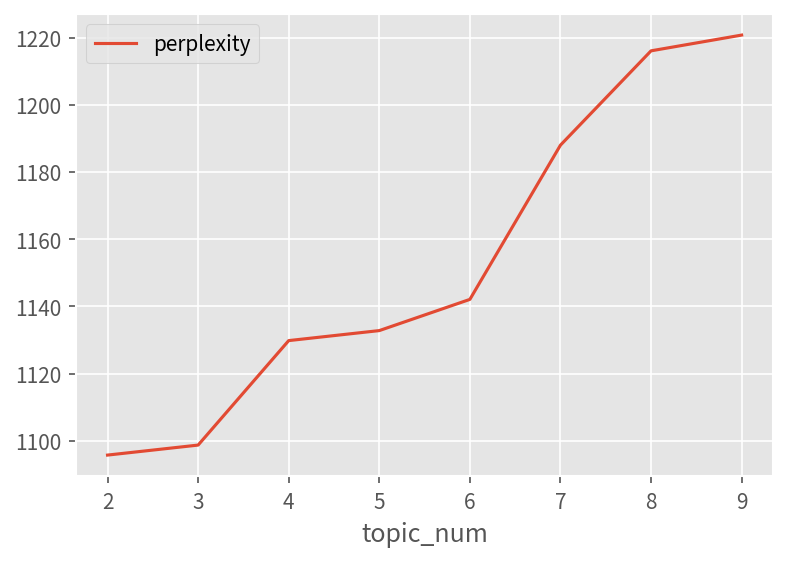

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

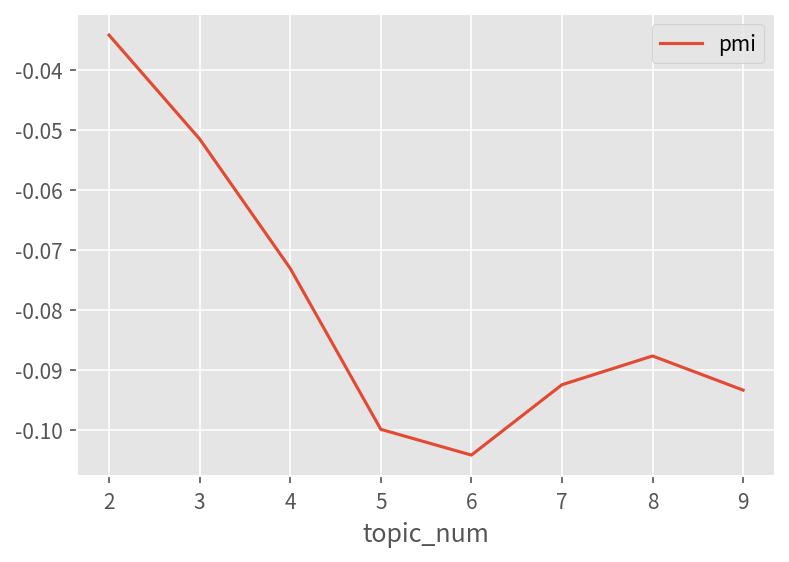

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，2個主題的效果最好，但我們查看發現2個主題太相像，所以最後使用4個主題進行分類

##### 視覺化呈現

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 4 來做 LDAvis 的結果範例

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-06-14 12:06:02,174 : INFO : using symmetric alpha at 0.25
2025-06-14 12:06:02,176 : INFO : using symmetric eta at 0.25
2025-06-14 12:06:02,179 : INFO : using serial LDA version on this node
2025-06-14 12:06:02,202 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 783 documents, updating model once every 783 documents, evaluating perplexity every 783 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-14 12:06:02,209 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-14 12:06:02,927 : INFO : -8.141 per-word bound, 282.3 perplexity estimate based on a held-out corpus of 783 documents with 37046 words
2025-06-14 12:06:02,931 : INFO : PROGRESS: pass 0, at document #783/783
2025-06-14 12:06:03,430 : INFO : topic #0 (0.250): 0.025*"演唱會" + 0.010*"新聞" + 0.008*"台灣" + 0.008*"活動" + 0.007*"巨蛋" + 0.007*"網友" + 0.006*"門票" + 0.006*"周杰倫" + 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.046583  0.021834       1        1  31.634719
1      0.096488 -0.013792       2        1  27.795449
2     -0.070027 -0.090722       3        1  21.486306
0     -0.073044  0.082681       4        1  19.083526, topic_info=    Term        Freq       Total Category  logprob  loglift
69   演唱會  626.000000  626.000000  Default  30.0000  30.0000
96    門票  388.000000  388.000000  Default  29.0000  29.0000
274   律師  103.000000  103.000000  Default  28.0000  28.0000
860   檢舉  143.000000  143.000000  Default  27.0000  27.0000
67    活動  130.000000  130.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
164   記者   35.504058  203.879287   Topic4  -5.2939  -0.0915
92    連結   27.891000   97.935527   Topic4  -5.5353   0.4003
79    網址   26.333177   88.432157   Topic4  -5.5927   0.4449
91    轉載   25.209876   79.850158   Topic4  -5.6363   0.5034
81    署名   25.738883   94.042722   Topic4  -5.6156   0.3606

[291 rows x 6 columns], token_table=      Topic      Freq Term
term                      
264       1  0.250406   一定
264       2  0.217018   一定
264       3  0.450730   一定
264       4  0.100162   一定
1727      1  0.855129   一顆
...     ...       ...  ...
1770      4  0.607049  麥當勞
176       1  0.294228  黃牛票
176       2  0.612974  黃牛票
176       3  0.049038  黃牛票
176       4  0.044951  黃牛票

[712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [ ]:
topics = model_5.show_topics(num_topics=4, num_words=10, formatted=False)
for i, topic in topics:
    words = [word for word, _ in topic]
    print(f"主題 {i}：{'、'.join(words)}")


主題 0：演唱會、活動、台灣、新聞、網友、日本、巨蛋、台北、媒體、粉絲
主題 1：黃牛票、檢舉、演唱會、票券、文化部、政府、新聞、萬元、民眾、記者
主題 2：台灣、律師、中國、萬元、梅西、新聞、日本、華為、手機、記者
主題 3：演唱會、門票、周杰倫、搶票、巨蛋、實名制、新聞、售票、警方、台北


| 主題 | 內容                      | 關鍵字                                     |
|----------|-------------------------------|-----------------------------------------------|
| 主題 0   | 活動與社群熱點                | 演唱會、媒體、網友、粉絲、台灣、日本、台北、巨蛋等跨地區活動與社群關注         |
| 主題 1   | 黃牛票爭議與政府措施          | 黃牛票、檢舉、票券炒作、文化部與政府的政策回應、媒體報導                        |
| 主題 2   | 跨國時事與法律爭議            | 中國、日本、華為、律師、手機、梅西等與新聞、國際與法律相關議題                 |
| 主題 3   | 明星演唱會與售票制度爭議      | 周杰倫演唱會、搶票、實名制、警方管理、售票系統、巨蛋與台北等相關事件             |


替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh02.html")

### GuidedLDA 文件分類

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.11.0` 可正常執行

In [ ]:
import guidedlda

In [ ]:
word2id = dictionary.token2id

In [ ]:
seed_topic_list = [
    ["演唱會", "活動", "網友", "媒體", "粉絲"],                 # 主題 0：活動與社群熱點
    ["黃牛票", "檢舉", "票券", "文化部", "政府", "民眾"],       # 主題 1：黃牛票爭議與政府措施
    ["律師", "中國", "梅西", "華為", "手機"],                  # 主題 2：跨國時事與法律爭議
    ["門票", "周杰倫", "搶票", "實名制", "售票", "警方"]        # 主題 3：明星演唱會與售票制度
]


In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-06-14 12:06:07,423 : INFO : n_documents: 783
2025-06-14 12:06:07,425 : INFO : vocab_size: 1800
2025-06-14 12:06:07,426 : INFO : n_words: 37046
2025-06-14 12:06:07,426 : INFO : n_topics: 6
2025-06-14 12:06:07,426 : INFO : n_iter: 100
2025-06-14 12:06:07,432 : WARNING : all zero row in document-term matrix found
2025-06-14 12:06:07,553 : INFO : <0> log likelihood: -368118
2025-06-14 12:06:07,666 : INFO : <20> log likelihood: -277093
2025-06-14 12:06:07,766 : INFO : <40> log likelihood: -273201
2025-06-14 12:06:07,876 : INFO : <60> log likelihood: -271603
2025-06-14 12:06:07,990 : INFO : <80> log likelihood: -270695
2025-06-14 12:06:08,086 : INFO : <99> log likelihood: -269755


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_
# 取得corpus全部的詞彙表
vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    # 依照詞語機率從小到大排序，找出每個主題的前十個關鍵詞
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 演唱會 新聞 媒體 巨蛋 台北 備註 記者 網友 粉絲 網址
Topic 1: 檢舉 票券 萬元 文化部 黃牛票 政府 律師 文化 民眾 案件
Topic 2: 中國 手機 台灣 華為 梅西 萬元 香港 大陸 蘋果 球迷
Topic 3: 門票 演唱會 周杰倫 搶票 警方 程式 售票 實名制 票券 機器人
Topic 4: 排隊 民眾 蛋黃 麥當勞 出現 開放 日本 貸款 伊卡 銀行
Topic 5: 台灣 演唱會 問題 黃牛票 八卦 實名制 門票 比較 活動 一張


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.265841  0.058116       1        1  23.887781
5      0.054934 -0.163379       2        1  23.272149
1     -0.027616  0.108944       3        1  17.801156
3      0.141273 -0.040600       4        1  14.700022
4     -0.197542  0.279959       5        1  10.572344
2     -0.236889 -0.243040       6        1   9.766548, topic_info=    Term        Freq       Total Category  logprob  loglift
96    門票  411.000000  411.000000  Default  30.0000  30.0000
69   演唱會  656.000000  656.000000  Default  29.0000  29.0000
538  周杰倫  248.000000  248.000000  Default  28.0000  28.0000
718   搶票  221.000000  221.000000  Default  27.0000  27.0000
316   中國  119.000000  119.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
464   之前   24.907533   48.876894   Topic6  -4.9785   1.6521
54    日本   35.862466  139.552026   Topic6  -4.6140   0.9675
274   律師   31.878854  107.763303   Topic6  -4.7318   1.1082
135   報導   26.899339  107.776706   Topic6  -4.9016   0.9382
323   一直   20.923921   55.849365   Topic6  -5.1528   1.3444

[364 rows x 6 columns], token_table=      Topic      Freq Term
term                      
510       6  0.998661   一位
264       2  0.873238   一定
264       4  0.129369   一定
1252      6  0.998119   一度
430       2  0.672371   一張
...     ...       ...  ...
1770      5  1.002441  麥當勞
176       1  0.038714  黃牛票
176       2  0.414244  黃牛票
176       3  0.356173  黃牛票
176       4  0.193572  黃牛票

[505 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 2, 4, 5, 3])

| Topic | 關鍵詞                | 主題方向         |
| ----- | -------------------- | ---------------- |
| 0     | 演唱會、媒體、巨蛋、網友、粉絲      | 社群反應與媒體報導        |
| 1     | 檢舉、黃牛票、政府、文化部、律師、案件  | 黃牛與法規執行          |
| 2     | 中國、手機、華為、梅西、台灣、蘋果、球迷 | 國際新聞／科技與名人爭議     |
| 3     | 周杰倫、搶票、警方、實名制、機器人、程式 | 演唱會搶票與技術防黃牛      |
| 4     | 排隊、蛋黃、麥當勞、伊卡、銀行、貸款   | 生活消費與現象級事件（非演唱會） |
| 5     | 演唱會、黃牛票、問題、實名制、八卦、活動 | 綜合演唱會與討論（論壇感）   |


In [ ]:
seed_topic_list = [
    ["演唱會", "媒體", "巨蛋", "網友", "粉絲"],                        # Topic 0：社群與媒體熱點
    ["黃牛票", "檢舉", "政府", "文化部", "律師", "民眾", "案件"],        # Topic 1：黃牛與法規執行
    ["中國", "手機", "華為", "梅西", "蘋果", "台灣", "球迷"],           # Topic 2：國際新聞與科技名人
    ["周杰倫", "搶票", "警方", "實名制", "售票", "程式", "機器人"],      # Topic 3：演唱會搶票與技術手段
    ["排隊", "蛋黃", "麥當勞", "伊卡", "銀行", "貸款"],                # Topic 4：生活話題與消費現象
    ["演唱會", "問題", "黃牛票", "活動", "八卦", "門票", "實名制"]       # Topic 5：綜合演唱會與論壇討論
]


seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-06-14 12:06:08,478 : INFO : n_documents: 783
2025-06-14 12:06:08,478 : INFO : vocab_size: 1800
2025-06-14 12:06:08,481 : INFO : n_words: 37046
2025-06-14 12:06:08,483 : INFO : n_topics: 6
2025-06-14 12:06:08,483 : INFO : n_iter: 100
2025-06-14 12:06:08,487 : WARNING : all zero row in document-term matrix found
2025-06-14 12:06:08,596 : INFO : <0> log likelihood: -364986
2025-06-14 12:06:08,699 : INFO : <20> log likelihood: -273727
2025-06-14 12:06:08,816 : INFO : <40> log likelihood: -270274
2025-06-14 12:06:08,920 : INFO : <60> log likelihood: -268555
2025-06-14 12:06:09,012 : INFO : <80> log likelihood: -267972
2025-06-14 12:06:09,100 : INFO : <99> log likelihood: -267389


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 演唱會 新聞 媒體 台北 記者 巨蛋 備註 來源 網友 新聞標題
Topic 1: 檢舉 律師 文化部 政府 案件 黃牛票 問題 提供 文化 地方
Topic 2: 台灣 中國 手機 香港 華為 梅西 大陸 蘋果 中心 寶可夢
Topic 3: 門票 票券 萬元 警方 搶票 周杰倫 程式 黃牛票 轉售 購買
Topic 4: 排隊 活動 日本 蛋黃 民眾 麥當勞 時間 貸款 銀行 伊卡
Topic 5: 演唱會 實名制 門票 台灣 周杰倫 黃牛票 搶票 票價 一張 八卦


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.062350 -0.024735       1        1  29.971754
0      0.293971 -0.031816       2        1  23.705403
3     -0.029743 -0.214578       3        1  16.482712
4     -0.127064 -0.182061       4        1  10.723669
1     -0.288541  0.156174       5        1  10.192599
2      0.089026  0.297016       6        1   8.923863, topic_info=    Term        Freq       Total Category  logprob  loglift
28    台灣  323.000000  323.000000  Default  30.0000  30.0000
69   演唱會  656.000000  656.000000  Default  29.0000  29.0000
860   檢舉  150.000000  150.000000  Default  28.0000  28.0000
37    媒體  217.000000  217.000000  Default  27.0000  27.0000
405   票券  177.000000  177.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
290   美國   20.920988   38.913210   Topic6  -5.0627   1.7959
161   萬元   28.887094  210.523925   Topic6  -4.7401   0.4302
98    開賣   21.916751  102.802346   Topic6  -5.0162   0.8709
471   原價   20.920988   67.833645   Topic6  -5.0627   1.2401
561   提供   19.925224   87.786775   Topic6  -5.1115   0.9335

[354 rows x 6 columns], token_table=      Topic      Freq Term
term                      
461       1  0.947501   一場
461       6  0.054143   一場
264       1  0.905272   一定
264       5  0.096993   一定
430       1  1.002528   一張
...     ...       ...  ...
376       4  0.218478   高價
1770      4  1.002625  麥當勞
176       1  0.511072  黃牛票
176       3  0.305869  黃牛票
176       5  0.185844  黃牛票

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 5, 2, 3])

| 主題編號 | 建議主題名稱                | 主題內容說明 |
|----------|-----------------------------|----------------|
| Topic 0  | 媒體報導與社群回應          | 聚焦演唱會相關新聞曝光、記者報導與網友反應，例如巨蛋事件、媒體標題與社群輿論等。 |
| Topic 1  | 黃牛與政策法律應對          | 包含黃牛票檢舉、文化部與政府的介入，反映法律制度對票券問題的回應。 |
| Topic 2  | 國際新聞與名人事件          | 集中於中國、科技品牌（華為、蘋果）、名人（梅西）等國際話題，非演唱會主軸。 |
| Topic 3  | 搶票問題與轉售爭議          | 討論搶票行為、票券轉售、警方與黃牛票的問題，偏向演唱會的市場與秩序問題。 |
| Topic 4  | 生活消費與排隊文化          | 涉及民眾排隊、蛋黃麥當勞等熱門話題，也出現貸款銀行等消費壓力相關詞彙。 |
| Topic 5  | 演唱會制度與論壇討論        | 強調演唱會購票流程（如實名制、票價）與論壇類討論內容如八卦板，屬社群討論主題。 |


### 主題分佈應用，搭配其他文章資訊

訓練完LDA模型後，我們可以嘗試將訓練好的模型應用於資料集上，觀察每天主題文章的佔比變化

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(1, 0.39359692), (3, 0.60468125)]

將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.02028684, 0.30917275, 0.02023158, 0.65030879],
       [0.3607116 , 0.24683017, 0.        , 0.39063072],
       [0.01860156, 0.01866488, 0.84132963, 0.1214039 ],
       ...,
       [0.92902035, 0.02334392, 0.02404378, 0.02359195],
       [0.        , 0.        , 0.        , 0.98203558],
       [0.25      , 0.25      , 0.25      , 0.25      ]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
udn['topic_label'] = m_theta.argmax(axis=1) + 1

統計一下各個主題的數量

In [ ]:
udn['topic_label'].value_counts()

topic_label
4    334
3    177
2    147
1    125
Name: count, dtype: int64

In [ ]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,他們家東西基本上吃過一次就好怎說食材擺出來就那樣以前沒在綁帳號的時候訂位滿方便的後來一堆黃牛...,https://www.ptt.cc/bbs/Gossiping/M.1705384822....,Gossiping,2024-01-16 14:00:20,"[吃過, 一次, 怎說, 食材, 擺出來, 以前, 帳號, 訂位, 方便, 亂搞, 綁定, ...",4
1,媒體來源民視新聞記者署名陳姵妡陳家祥完整新聞標題大港開唱開賣秒殺全實名制杜絕黃牛國內外天團夢...,https://www.ptt.cc/bbs/Gossiping/M.1705420841....,Gossiping,2024-01-17 00:00:39,"[媒體, 來源, 民視, 新聞記者, 署名, 陳家, 新聞標題, 大港, 開唱, 開賣, 秒...",4
2,各位阿肥好本肥百思不解演唱會票黃牛被人撻伐原因是大量佔為己有那房市也是有一些人佔為己有導致價...,https://www.ptt.cc/bbs/Gossiping/M.1705741959....,Gossiping,2024-01-20 17:12:37,"[阿肥, 本肥, 百思不解, 演唱會, 撻伐, 原因, 大量, 為己, 房市, 一些, 為己...",3
3,新莊秀台語打給厚飆唱億神曲粉瘋狂記者陳薇安新北報導日本天團為動畫我推的孩子創作演唱創下串流音...,https://www.ptt.cc/bbs/Gossiping/M.1705843798....,Gossiping,2024-01-21 21:29:55,"[新莊, 秀台語, 打給, 神曲, 瘋狂, 記者, 安新北, 報導, 日本, 天團, 動畫,...",3
4,媒體來源今日新聞記者署名陳雅蘭完整新聞標題完整新聞內文日本人氣雙人組合今日晚間點將在新莊開唱...,https://www.ptt.cc/bbs/Gossiping/M.1705923767....,Gossiping,2024-01-22 19:42:45,"[媒體, 來源, 今日, 新聞記者, 署名, 雅蘭, 新聞標題, 新聞, 內文, 日本, 人...",1


查看每天每個主題的文章相對比例（占比）

In [ ]:
# udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)
udn.groupby(udn['artDate'].dt.to_period('M'))['topic_label'].value_counts(normalize=True)


artDate  topic_label
2024-01  3              0.500000
         4              0.250000
         1              0.125000
         2              0.125000
2024-02  3              0.450000
         2              0.200000
         4              0.200000
         1              0.150000
2024-03  4              0.465116
         1              0.186047
         2              0.186047
         3              0.162791
2024-04  4              0.420000
         2              0.300000
         1              0.140000
         3              0.140000
2024-05  3              0.379310
         4              0.275862
         2              0.206897
         1              0.137931
2024-06  4              0.392857
         3              0.285714
         1              0.214286
         2              0.107143
2024-07  4              0.347826
         1              0.260870
         2              0.260870
         3              0.130435
2024-08  1              0.482759
         4            

In [ ]:
# date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic = udn.groupby(udn['artDate'].dt.to_period('M'))['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4
artDate,,,,
2024-01,0.125000,0.125000,0.500000,0.250000
2024-02,0.150000,0.200000,0.450000,0.200000
2024-03,0.186047,0.186047,0.162791,0.465116
2024-04,0.140000,0.300000,0.140000,0.420000
2024-05,0.137931,0.206897,0.379310,0.275862


##### 視覺化呈現主題文章趨勢變化

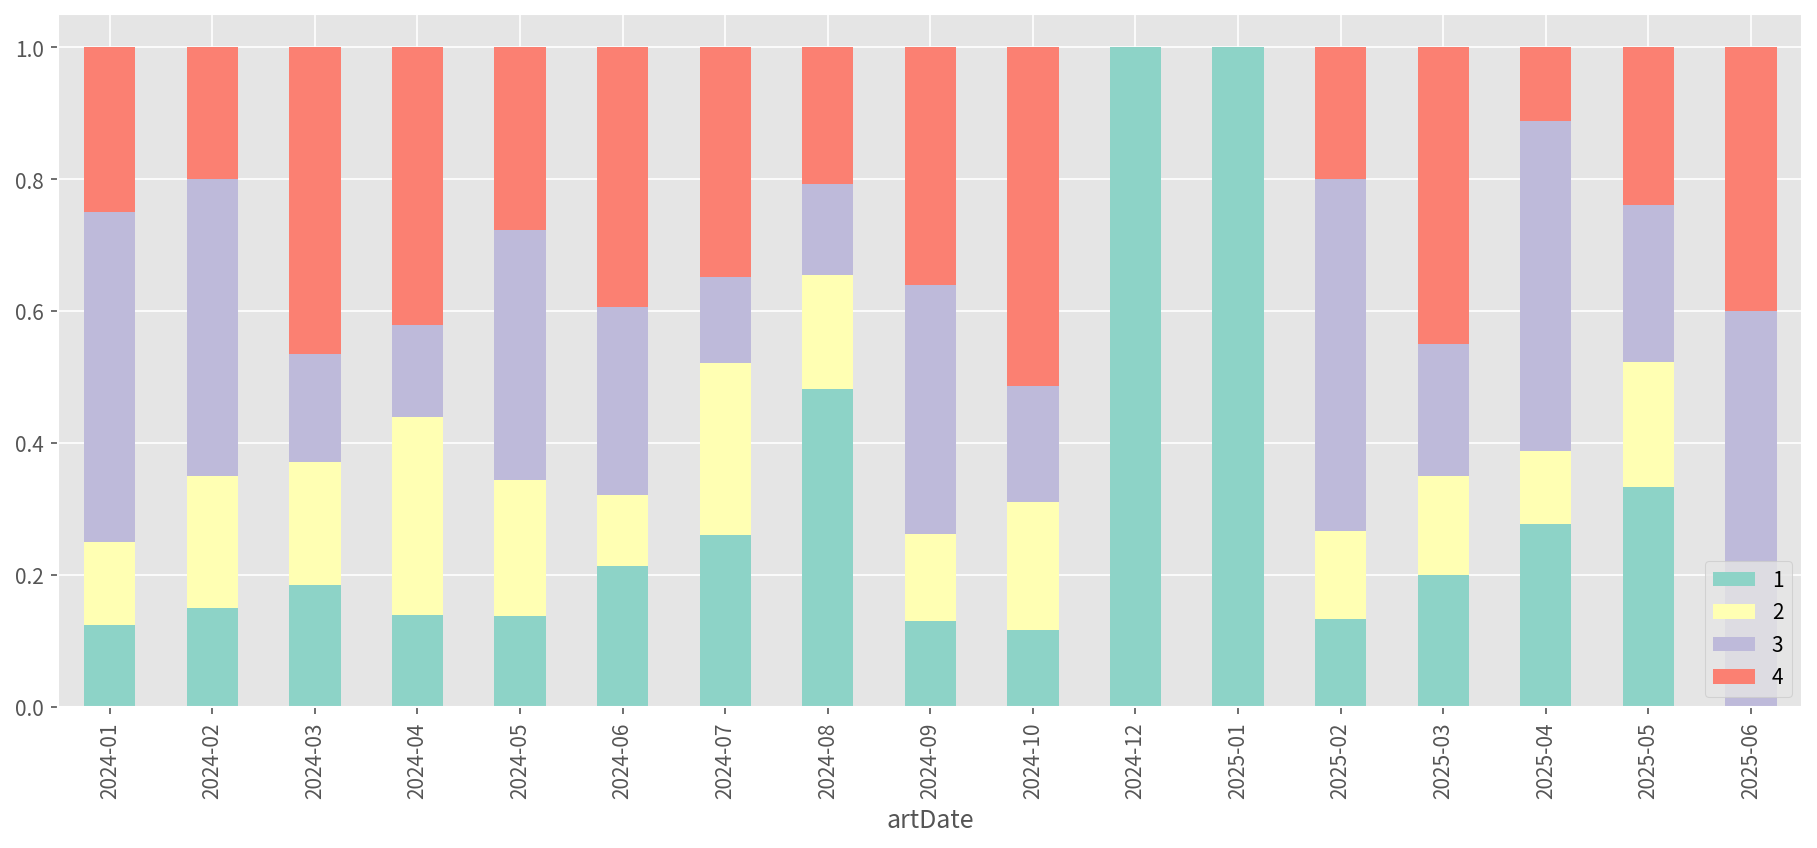

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

2024/12和2025/01的主題全部都為主題一，查看資料後發現，這兩個月的文章都只有一篇，所以導致主題只有一個。

### 結論

透過黃牛的文章分析後，可以發現在演唱會賣票期間的文章數較多，且黃牛相關的文章負向情緒也較多，而文章數也會依照大眾性而有所不同，但我們原本想要透過文件分類查看更多領域的黃牛情形，分析完後發現分類的結果都有點相像，這是與我們預期的情況不相同的，可能跟我們資料集的種類、數量有關，之後可以從更多平台收集資料來擴展文章種類，以此來提升我們的分類效果。